In [1]:
from orion.data import load_signal, load_anomalies

# 1. Data

In [ ]:
signal_name = 'P-1'

data = load_signal(signal_name)

print(len(data))
anomalies = load_anomalies(signal_name)

data.head()

P-1: 11377
S-1: 10149
E-1: 11396
E-2: 11412
E-3: 11187
E-4: 11234
E-5: 11174
E-6: 11180
E-7: 11079
E-8: 11412
E-9: 11182
E-10: 11385
E-11: 11394
E-12: 11392
E-13: 11520
A-1: 11520
D-1: 11358
P-3: 11348
D-2: 11475
D-3: 11520
D-4: 11306
A-2: 10562
A-3: 10941
A-4: 10770
G-1: 11289
G-2: 9839
D-5: 10189
D-6: 10478
D-7: 10225
F-1: 11453
P-4: 10392
G-3: 10531
T-1: 11487
T-2: 11480
D-8: 10476
D-9: 9989
F-2: 11487
G-4: 10183
T-3: 11455
D-11: 10042
D-12: 8230
B-1: 10479
G-6: 11521
G-7: 10475
P-7: 10924
R-1: 10118
A-5: 5398
A-6: 5135
A-7: 11510
D-13: 9153
A-8: 9137
A-9: 9196
F-3: 11256
M-6: 3614
M-1: 4486
M-2: 4485
S-2: 2753
P-10: 10408
T-4: 4489
T-5: 4490
F-7: 7565
M-3: 4164
M-4: 4114
M-5: 4335
P-15: 6538
C-1: 4422
C-2: 2815
T-12: 3575
T-13: 3575
F-4: 5666
F-5: 6520
D-14: 6300
T-9: 1535
P-14: 8980
T-8: 2267
P-11: 7504
D-15: 4232
D-16: 3642
M-7: 3743
F-8: 5829


HTTPError: HTTP Error 404: Not Found

# 2. Pipeline

In [3]:
from mlblocks import MLPipeline

pipeline_name = 'cisco'

pipeline = MLPipeline(pipeline_name)

hyperparameters = {
    'mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1': {
        'interval': 21600
    },
    "mlstars.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        "target_column": 0,
        "window_size": 250,
        "step_size": 1
    },
}

pipeline.set_hyperparameters(hyperparameters)

/home/baranov/miniconda/envs/orion310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0].


Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 61166.93it/s]


## step by step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its `primtivies` attribute. 

The `Cisco` pipeline contains 6 primitives. we will observe how the `context` (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [4]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'mlstars.custom.timeseries_preprocessing.rolling_window_sequences',
 'orion.primitives.cisco.Cisco',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    - `X` sequence of aggregated values, one column for each aggregation method.
    - `index` sequence of index values (first index of each aggregated segment).

In [5]:
context = pipeline.fit(data, output_=0)
context.keys()

dict_keys(['X', 'index'])

In [6]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.36635895]
entry at 1222840800 has value [-0.39410778]
entry at 1222862400 has value [0.4036246]
entry at 1222884000 has value [-0.36275906]
entry at 1222905600 has value [-0.37074649]


In [7]:
# Check data length after aggregation
print(f"Data length after aggregation: {len(context['X'])}")
print(f"Required window_size: 30720")
print(f"Available data: {len(context['X'])}")
if len(context['X']) < 30720:
    print(f"\n⚠️ WARNING: window_size (30720) is larger than available data ({len(context['X'])}).")
    print("This will result in 0 sequences. Consider:")
    print("  1. Using more raw data (remove the [:50000] slice)")
    print("  2. Using a smaller aggregation interval")
    print("  3. Reducing window_size in pipeline hyperparameters")

Data length after aggregation: 10149
Required window_size: 30720
Available data: 10149

⚠️ WARNING: window_size (30720) is larger than available data (10149).
This will result in 0 sequences. Consider:
  1. Using more raw data (remove the [:50000] slice)
  2. Using a smaller aggregation interval
  3. Reducing window_size in pipeline hyperparameters


### SimpleImputer
this primitive is an imputation transformer for filling missing values.
* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a transformed version of X.

In [8]:
step = 1

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

### rolling window sequence
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.

* **input**: 
    - `X` n-dimensional sequence to iterate over.
    - `index` array containing the index values of X.
* **output**:
    - `X` input sequences.
    - `y` target sequences.
    - `index` first index value of each input sequence.
    - `target_index` first index value of each target sequence.

In [9]:
step = 2

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X', 'y', 'target_index'])

In [10]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)
# and similarly y is (# slices, target size)
# Note: Cisco uses a large window_size (30720) for long-term context

print("X shape = {}\ny shape = {}\nindex shape = {}\ntarget index shape = {}".format(
    context['X'].shape, context['y'].shape, context['index'].shape, context['target_index'].shape))

X shape = (9899, 250, 1)
y shape = (9899, 1)
index shape = (9899,)
target index shape = (9899,)


### Cisco
this is a forecasting using Cisco's multi-resolution Time Series Foundation Model. you can read more about it in the [related paper](https://arxiv.org/pdf/2511.19841).

Cisco uses a multi-resolution approach with both coarse (long-term) and fine (short-term) contexts to make predictions.

* **input**: 
    - `X` n-dimensional array containing the input sequences for the model.
* **output**: 
    - `y_hat` predicted values

In [11]:
step = 3

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'target_index', 'X', 'y', 'y_hat'])

In [12]:
context['y_hat'].shape

(9899, 128)

### regression errors

this primitive computes an array of errors comparing predictions and expected output.

* **input**: 
    - `y` ground truth.
    - `y_hat` forecasted values.
* **output**: `errors` array of errors.

In [13]:
step = 4

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'target_index', 'y_hat', 'X', 'y', 'errors'])

### find anomalies

this primitive finds anomalies from sequence of errors

* **input**: 
    - `errors` array of errors
    - `target_index` indices
* **output**: `anomalies`.

In [14]:
step = 5

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'target_index', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [15]:
context['anomalies']

array([[1.22821920e+09, 1.22942880e+09, 5.04740129e-01]])

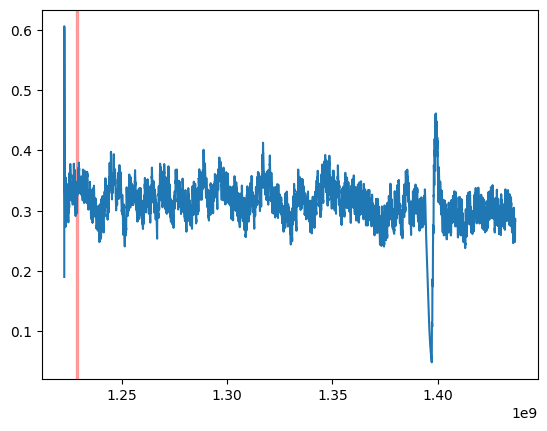

In [20]:
import matplotlib.pyplot as plt

plt.plot(context['index'], context['errors'])
for anomaly in context['anomalies']:
    plt.axvspan(anomaly[0], anomaly[1], color='red', alpha=0.3)
plt.show()


## 3. Evaluate performance

In this next step we will load some already known anomalous intervals and evaluate how
good our anomaly detection was by comparing those with our detected intervals.

For this, we will first load the known anomalies for the signal that we are using:

In [16]:
from orion.data import load_anomalies

ground_truth = load_anomalies('S-1')
ground_truth

,start,end
0,1398168000,1407823200


In [17]:
anomalies = []
for ano in context['anomalies']:
    anomalies.append((ano[0], ano[1]))
anomalies

[(1228219200.0, 1229428800.0)]

In [18]:
from orion.evaluation import contextual_confusion_matrix, contextual_f1_score

start, end = context['index'][0], context['index'][-1]

contextual_confusion_matrix(ground_truth, anomalies, start = start, end = end, weighted=False)

(None, 1, 1, 0)

In [19]:
contextual_f1_score(ground_truth, anomalies, start = start, end = end, weighted=False)

Invalid value encountered for precision 0.0/ recall 0.0.
Traceback (most recent call last):
  File "/home/baranov/projects/Orion/orion/evaluation/common.py", line 70, in _f1_score
    return 2 * (precision * recall) / (precision + recall)
ZeroDivisionError: float division by zero


nan